# An Application to Mango Patchiness Analysis

Recently, a statistical methodology has been proposed to characterize plant patchiness at the plant scale [[FDDPLNG16](http://ieeexplore.ieee.org/abstract/document/7818290)].
However, little is known about patchiness at the whole population scale.
To characterize patchiness at the plant scale, a segmentation/clustering of tree-indexed data method has been proposed in order to split an heterogeneous tree into multiple homogeneous subtrees.
After the clustering, the tree can be summarized into a multivariate count denoting the number of subtrees in each cluster (i.e., patch type).
Mixture of multinomial splitting distributions can therefore be considered to recover the different types of tree patchiness that can be found in the plant population.
Such a mixture model is of high interest since it enables to discriminate the types of tree patchiness according to the :

* number of patches present on trees, by fitting different sum distributions within components of the mixture model,
* distribution of these patches among types, by fitting different singular distributions within components of the mixture model.

We here consider results presented by [[FDDPLNG16](http://ieeexplore.ieee.org/abstract/document/7818290)] to conduct our *post-hoc* analysis.
Three different types of patches have been identified for mango trees: vegetative patches which contain almost only vegetative growth units (GU, plant elementary component), reproductive patches which contain almost only GUs that flowered or fructified and quiescent patches which contain GUs that did not burst, flowered nor fructified.

First, we need:
    
* to import `matplotlib` package.

In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

* to import `linalg` and `core` modules of the `statiskit` package.

In [2]:
from statiskit import (linalg,
                       core)

* to load the dataset.

In [3]:
from statiskit.data import core as data
data = data.load('FPD18')

Multinomial splitting distributions of mixture components were of dimension $3$, where $N_0$ (resp. $N_1$ and $N_2$) denotes the number of vegetative (resp. reproductive and quiescent) patches observed within a tree.
Only the multinomial and the Dirichlet multinomial  were considered for the singular distribution.
Within each component the parametric form of the singuar distribution was selected using the BIC.

In [4]:
singular_estimator = core.singular_selection('MN', 'DM')

Since there is at least one patch in a mango tree (i.e., the tree itself), shifted singular multinomial splitting distributions were considered with a shift equal to $1$ for binomial, negative binomial and Poisson sum distributions but without shift for geometric and logarithmic distributions.
Within each component the parametric form of the sum distribution was selected using the BIC.

In [5]:
sum_estimator = core.shifted_estimation(core.outcome_type.DISCRETE,
                                        shift = 1,
                                        estimator = core.selection(core.outcome_type.DISCRETE,
                                                                   estimators = [core.poisson_estimation('ml'),
                                                                                 core.binomial_estimation('ml'),
                                                                                 core.negative_binomial_estimation('ml')]))
sum_estimator = core.selection(core.outcome_type.DISCRETE,
                               estimators = [sum_estimator,
                                             core.geometric_estimation('ml'),
                                             core.logarithmic_estimation('ml')])

With `singular_estimator` and `sum_estimator` we are now able to construct an estimator for a splitting distribution.

In [6]:
estimator = core.splitting_estimation(sum = sum_estimator,
                                      singular = singular_estimator)

The initilization of the EM alogrithm is made with a mixture of $27$ components with slight differences concerning multinomial singular distribution probabilities.

In [7]:
import itertools
pi = [1.] * len(data.components)
components = []
for alpha in itertools.product(*([(1.,2.,3.)] * 3)):
    components.append(core.SplittingDistribution(core.PoissonDistribution(1.),
                                                 core.MultinomialSingularDistribution(linalg.Vector(alpha))))
initializator = core.MixtureDistribution(*components,
                                         pi = linalg.Vector([1.] * len(components)))
mixest = [core.mixture_estimation(data, 'em',
                                  initializator = initializator,
                                  default_estimator = estimator)]

We then estimate the mixture models with an initialization were components less observed *a posteriori* are successively removed.

In [8]:
while len(components) > 2:
    assignment = list(mixest[-1].estimated.assignment(data))
    components.pop(min(set(assignment), key=assignment.count))
    initializator = core.MixtureDistribution(*components,
                                             pi = linalg.Vector([1.] * len(components)))
    mixest.append(core.mixture_estimation(data, 'em',
                                           initializator = initializator,
                                           default_estimator = estimator, maxits=100))

We also considered the case where there is only one component.

In [9]:
mixest.append(estimator(data, False))
mixest = list(reversed(mixest))

To select the best number of components, we used the BIC.

<IPython.core.display.Javascript object>


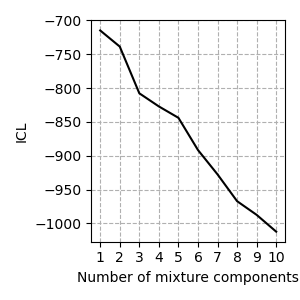

In [10]:
import math
Sm = [result.estimated.loglikelihood(data) for result in mixest]
Dm = [mixest[0].estimated.nb_parameters] + [result.estimated.nb_parameters for result in mixest[1:]]
BICm = [s - d * math.log(data.total) / 2 for s, d in zip(Sm, Dm)]
Cm = [1] + [result.estimated.nb_states for result in mixest[1:]]
Um = [0] + [result.estimated.uncertainty(data) for result in mixest[1:]]
ICLm = [bic - u for (bic, u) in zip(BICm, Um)]
limit = 10
fig = pyplot.figure(figsize=(3,3))
axes = fig.add_subplot(111)
axes.plot(Cm[:limit], ICLm[:limit], color='k')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('ICL')
axes.grid(linestyle='--')
pyplot.tight_layout()
try:
    fig.savefig('selection.pgf')
except:
    pass
fig.savefig('selection.svg')

<IPython.core.display.Javascript object>


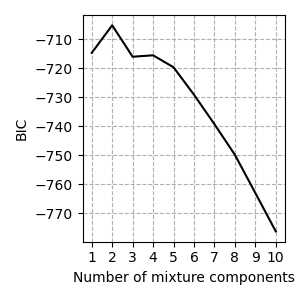

In [16]:
fig = pyplot.figure(figsize=(3,3))
axes = fig.add_subplot(111)
axes.plot(Cm[:limit], BICm[:limit], color='k')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('BIC')
axes.grid(linestyle='--')
pyplot.tight_layout()
try:
    fig.savefig('selection.pgf')
except:
    pass
fig.savefig('selection.svg')

The best number of components is $2$ with relatively similar representation

In [11]:
mixest[1].estimated.pi

[0.44293418528393547]
[ 0.5570658147160645]

In component $1$, the best observation distribution is a multinomial splitting shifted negative binomiale .

In [12]:
mixest[1].estimated.observations[0]

M(S, [   0.21249080758585762]
[2.0476309246870988e-06]
[    0.7875071447832177]) /\ NB(0.1637753477934285, 0.761604080906057, 1)

This is also true in component $2$

In [13]:
mixest[1].estimated.observations[1]

M(S, [ 0.5438353029024995]
[0.17544277328126304]
[ 0.2807219238162374]) /\ NB(4.072049442041935, 0.39558799178622117, 1)

To appreciate the fit of this model, on can look at the fit of the sum distributions for example.

<IPython.core.display.Javascript object>


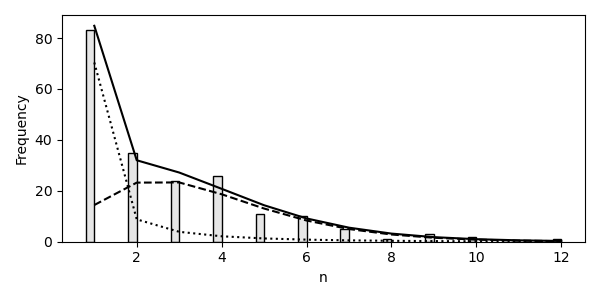

In [14]:
sum_data = core.from_list([sum([event.value for event in events]) for events in data.events])
dist = mixest[1].estimated
fig = pyplot.figure(figsize=(6,3))
sum_dist = core.MixtureDistribution(dist.observations[0].sum,
                                    dist.observations[1].sum,
                                    pi = dist.pi)
axes = sum_dist.pdf_plot(axes = fig.add_subplot(111),
                         color = 'k',
                         fmt = '-',
                         norm = sum_data.total,
                         qmin = sum_data.min.value,
                         qmax = sum_data.max.value,
                         states = [dict(fmt = ':'),
                                   dict(fmt = '--')])
axes = sum_data.pdf_plot(axes = axes, color='#e6e6e6',
                                      edgecolor='k')
axes.set_xlabel('n')
axes.set_ylabel('Frequency')
pyplot.tight_layout()
try:
    fig.savefig('sum.pgf')
except:
    pass
fig.savefig('sum.svg')

Note that if we consider only $1$ component, the best model is a Dirichlet multinomial splitting geometric distribution.

In [15]:
mixest[0].estimated

DM(S, [ 3.067705285098288]
[0.8679624628318171]
[  2.98830062597658]) /\ G(0.6318681318681323)